In [30]:
import re
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from pathlib import Path
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.io import imread
import torchvision
from torch.utils.data import Dataset

In [31]:
def del_empty_dirs(path: str):
    for d in os.listdir(path):
        a = os.path.join(path, d)
        if os.path.isdir(a):
            del_empty_dirs(a)
            if not os.listdir(a):
                os.rmdir(a)
                print(a, 'was deleted')
del_empty_dirs('C:/may/ML/GroupLe/grouple/data/face_detection/processed')

In [32]:
filecount=0
for dirpath, dirs, files in os.walk('C:/may/ML/GroupLe/grouple/data/face_detection/processed'):
    for filename in files:
        filecount+=1
filecount

21862

In [33]:
def walkdir(folder):
    """Walk through every files in a directory"""
    for dirpath, dirs, files in os.walk(folder):
        for filename in files:
            return str(os.path.abspath(os.path.join(dirpath, filename)))

In [34]:
import torchvision.transforms as T
    
class EmptyTransformation(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, img):
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


In [35]:
composed = torchvision.transforms.Compose([T.ToTensor(),
                                           T.Resize((128, 128)),
                                           T.RandomChoice((#T.Grayscale(), 
                                                          T.ColorJitter(0.1, 0.1, 0.1),
                                                          T.RandomRotation(degrees=(0, 60)),
                                                          EmptyTransformation())
                                                          )])

In [55]:
class SiamseDatasetPath(Dataset):
    def __init__(self, data_path: Path, transform = None):
        self.data_path = data_path
        self.transform = transform
        self.anchor_paths, self.positive_paths, self.negative_paths = self.make_triplets_dataset()
        
    def __len__(self):
        filecount = 0
        for dirpath, dirs, files in os.walk(self.data_path):
            for filename in files:
                filecount+=1
        return filecount
        
    def __getitem__(self, idx) -> torch.Tensor:
        return self.transform(self.load_image(self.anchor_paths[idx])), self.transform(self.load_image(self.positive_paths[idx])), self.transform(self.load_image(self.negative_paths[idx]))    

    @staticmethod
    def load_image(path: Path) -> np.ndarray:
        image = cv2.imread(path)
        return image
        
    def make_triplets_dataset(self) -> list:
        anchor_paths = []
        positive_paths = []
        negative_paths = []
        
        for folder in tqdm(os.listdir(self.data_path)):
            cur_path = os.path.join(self.data_path, folder)

            for file in os.listdir(cur_path):

                path_anc = os.path.join(cur_path, file)
                path_pos = os.path.join(cur_path, random.choice(os.listdir(cur_path)))
                        
                name_neg = random.choice(os.listdir(self.data_path))
                path_neg = os.path.join(self.data_path, name_neg)               
            
                anchor_paths.append(path_anc)
                positive_paths.append(path_pos)
                negative_paths.append(path_neg + '\\' + random.choice(os.listdir(path_neg)))
                                            
        return [anchor_paths, positive_paths, negative_paths]
    
    
class SiamseDatasetPics(Dataset):
    def __init__(self, data_path: Path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.anchor, self.positive, self.negative = self.make_triplets_dataset()
        
    def __len__(self):
        return len(self.anchor)
    
    def __getitem__(self, idx) -> torch.Tensor:
        return self.transform(self.anchor[idx]), self.transform(self.positive[idx]), self.transform(self.negative[idx])
        
    @staticmethod
    def load_image(path: Path) -> np.ndarray:
        image = cv2.imread(path)
        return image
    
    def make_triplets_dataset(self) -> list:
        anchor_images = []
        positive_images = []
        negative_images = []

        for folder in tqdm(os.listdir(self.data_path)):
            cur_path = os.path.join(self.data_path, folder)

            for file in os.listdir(cur_path):

                path_anc = os.path.join(cur_path, file)
                path_pos = os.path.join(cur_path, random.choice(os.listdir(cur_path)))

                name_neg = random.choice(os.listdir(self.data_path))
                path_neg = os.path.join(self.data_path, name_neg)

                a_image = self.load_image(path_anc)
                pos_image = self.load_image(path_pos)
                neg_image = self.load_image(path_neg + '/' + random.choice(os.listdir(path_neg))) 

                anchor_images.append(a_image)
                positive_images.append(pos_image)
                negative_images.append(neg_image)

        return [np.array(anchor_images), np.array(positive_images), np.array(negative_images)]


In [57]:
import torchvision
siamse_dataset = SiamseDatasetPath(Path('C:/may/ML/GroupLe/grouple/data/face_detection/processed'), transform = composed)

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:11<00:00,  2.17it/s]


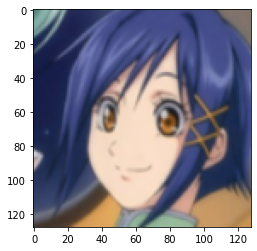

In [58]:
pic = siamse_dataset.__getitem__(1)[1]
plt.imshow(pic.permute(1, 2, 0))

In [59]:
siamse_dataset_train, siamse_dataset_test = torch.utils.data.random_split(siamse_dataset,
                                                                         (round(len(siamse_dataset)*0.8),
                                                                          int(len(siamse_dataset)*0.2)))

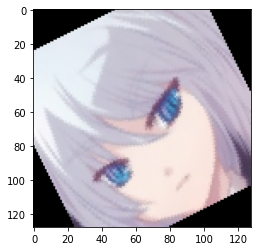

In [60]:
plt.imshow(siamse_dataset_train.__getitem__(2)[1].permute(1, 2, 0))

In [61]:
from torch.utils.data import DataLoader
batch_size = 10
train_dl = DataLoader(siamse_dataset_train, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(siamse_dataset_test, batch_size = batch_size, shuffle = True)

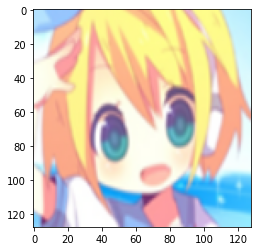

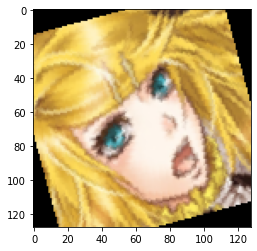

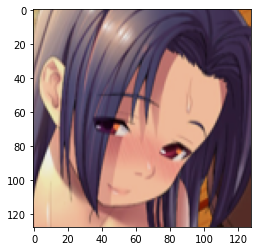

1749
438


In [62]:
for i in train_dl:
    plt.imshow(i[0][0].permute(1, 2, 0))#anchor
    plt.show()
    plt.imshow(i[1][0].permute(1, 2, 0)) #positive
    plt.show()
    plt.imshow(i[2][0].permute(1, 2, 0)) #negative
    plt.show()
    break
    
print(len(train_dl))
print(len(test_dl))

In [63]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3),
                                     nn.ReLU(),
                                         
                                     nn.Conv2d(in_channels=9, out_channels=15, kernel_size=3), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))
                                                  
        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=15, out_channels=18, kernel_size=5), 
                                     nn.ReLU(),
                                         
                                     nn.Conv2d(in_channels=18, out_channels=27, kernel_size=5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                         
                                     nn.Conv2d(in_channels=27, out_channels=33, kernel_size=17), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(825, 768),
                                nn.ReLU(),
                                nn.Linear(768, 512),
                                nn.ReLU(),
                                nn.Linear(512, 256) 
                                )

    def forward(self, x):
        output = self.conv_block1(x)
        output = self.conv_block2(output)                                         

        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [64]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [65]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

In [66]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True): #с нормой, размерности
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1) 
        losses = F.relu(distance_positive - distance_negative + self.margin)
        #print(losses.size())
        return losses.mean() if size_average else losses.sum()


In [67]:
# def triplet_loss(anchor, positive, negative):
#     a_p = cos(anchor, positive)
#     a_n = cos(anchor, negative)
#     norma = np.linalg.norm
#     loss = max((norma(a_p.detach().numpy()) - norma(a_n.detach().numpy())) + margin, 0)
#     #print(loss.size())
#     return loss

In [68]:
def accuracy(anchor, positive, negative):
    total_correct = 0
    cos = nn.CosineSimilarity()
    a_p = cos(anchor, positive)
    a_n = cos(anchor, negative)
    for i in range(len(a_p)-1):
        total_correct=total_correct+1 if a_p[i]>a_n[i] else total_correct
    return total_correct/batch_size

In [69]:
margin = 1
loss = TripletLoss(margin)

In [70]:
from torch.utils.tensorboard import SummaryWriter

In [71]:
from statistics import mean

def train_model(model, epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    writer = SummaryWriter('runs')
    
    for epoch in range(epochs):
        
        print('\n\n')
        print('------- EPOCH', epoch, '--------' )
        
        train_prebs_history = []
        train_loss_history = []
        train_accuracy_history = []
        
        test_accuracy_history = []
        test_preds_history = []
        test_loss_history = []
        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_dl), total = len(train_dl)):

            optimizer.zero_grad()
            
            preds = model.forward(anchor, positive, negative)

            output = loss.forward(preds[0], preds[1], preds[2])
            train_loss_history.append(output)
            writer.add_scalar('Loss/train', output, batch_idx + (len(train_dl)/batch_size) * epoch)
            
            output.backward() #считаем градиенты
            optimizer.step() #обновляем параметры/веса
            
            cur_accuracy = accuracy(preds[0], preds[1], preds[2])
            train_accuracy_history.append(cur_accuracy)
            writer.add_scalar('Accuracy/train', cur_accuracy, batch_idx + (len(train_dl)/batch_size) * epoch)
            
        print('train accuracy: ', mean(train_accuracy_history))
#         print('train loss: ', mean(train_loss_history))
        

        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_dl), total = len(test_dl)):
            
            test_preds = model.forward(anchor, positive, negative)
            cur_accuracy = accuracy(test_preds[0], test_preds[1], test_preds[2])
            test_accuracy_history.append(cur_accuracy)
            writer.add_scalar('Accuracy/train', cur_accuracy, batch_idx + (len(test_dl)/batch_size) * epoch)
            
            with torch.no_grad():
                test_loss = loss.forward(test_preds[0], test_preds[1], test_preds[2])
                test_loss_history.append(test_loss)
                writer.add_scalar('Loss/test', test_loss, batch_idx + (len(test_dl)/batch_size) * epoch)
                
        print('test accuracy: ', mean(test_accuracy_history))
#         print('test loss: ', mean(test_loss_history))
            

In [ ]:
train_model(model)

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]




------- EPOCH 0 --------


 10%|███████▊                                                                       | 174/1749 [02:54<27:33,  1.05s/it]

In [896]:
from torchsummaryX import summary
for batch_idx, (a, p, n) in tqdm(enumerate(train_dl), total = len(train_dl)):
    summary(model, a, p, n)
    break

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]

torch.Size([10, 825])
torch.Size([10, 825])
torch.Size([10, 825])

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]


                                              Kernel Shape  \
Layer                                                        
0_embedding_net.conv_block1.Conv2d_0          [3, 9, 3, 3]   
1_embedding_net.conv_block1.ReLU_1                       -   
2_embedding_net.conv_block1.Conv2d_2         [9, 15, 3, 3]   
3_embedding_net.conv_block1.ReLU_3                       -   
4_embedding_net.conv_block1.MaxPool2d_4                  -   
5_embedding_net.conv_block2.Conv2d_0        [15, 18, 5, 5]   
6_embedding_net.conv_block2.ReLU_1                       -   
7_embedding_net.conv_block2.Conv2d_2        [18, 27, 5, 5]   
8_embedding_net.conv_block2.ReLU_3                       -   
9_embedding_net.conv_block2.MaxPool2d_4                  -   
10_embedding_net.conv_block2.Conv2d_5     [27, 33, 17, 17]   
11_embedding_net.conv_block2.ReLU_6                      -   
12_embedding_net.conv_block2.MaxPool2d_7                 -   
13_embedding_net.fc.Linear_0                    [825, 768]   
14_embe